## Guitar tuner

In this notebook, I demonstrate how to:
1) decompose a signal into the original frequencies and amplitudes that make it up using fast fourier transforms (fft)
2) determine the string and played note and its cent accuracy using fft, rolling average

In [10]:
#relevant libraries
import scipy.io.wavfile as wavfile
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#read sample rates and signals from wav files
sample_rate_1, string_1 = wavfile.read('string_1.wav')
sample_rate_2, string_2 = wavfile.read('string_2.wav')
sample_rate_3, string_3 = wavfile.read('string_3.wav')

signals = [string_1, string_2, string_3]
sample_rates = [sample_rate_1, sample_rate_2, sample_rate_3]
durations = [len(string_1)/sample_rate_1, len(string_2)/sample_rate_2, len(string_3)/sample_rate_3]

#introduce the strings and respective values for cent accuracy
strings = {"E1" : 329.63, "B2" : 246.94, "G3" : 196.00, "D4" : 146.83, "A5" : 110.00, "E6" : 82.41}
cent_accuracies = {"E1" : 0.15, "B2" : 0.15, "G3" : 0.15, "D4" : 0.08, "A5" : 0.08, "E6" : 0.04}


##### Visualize the signals.

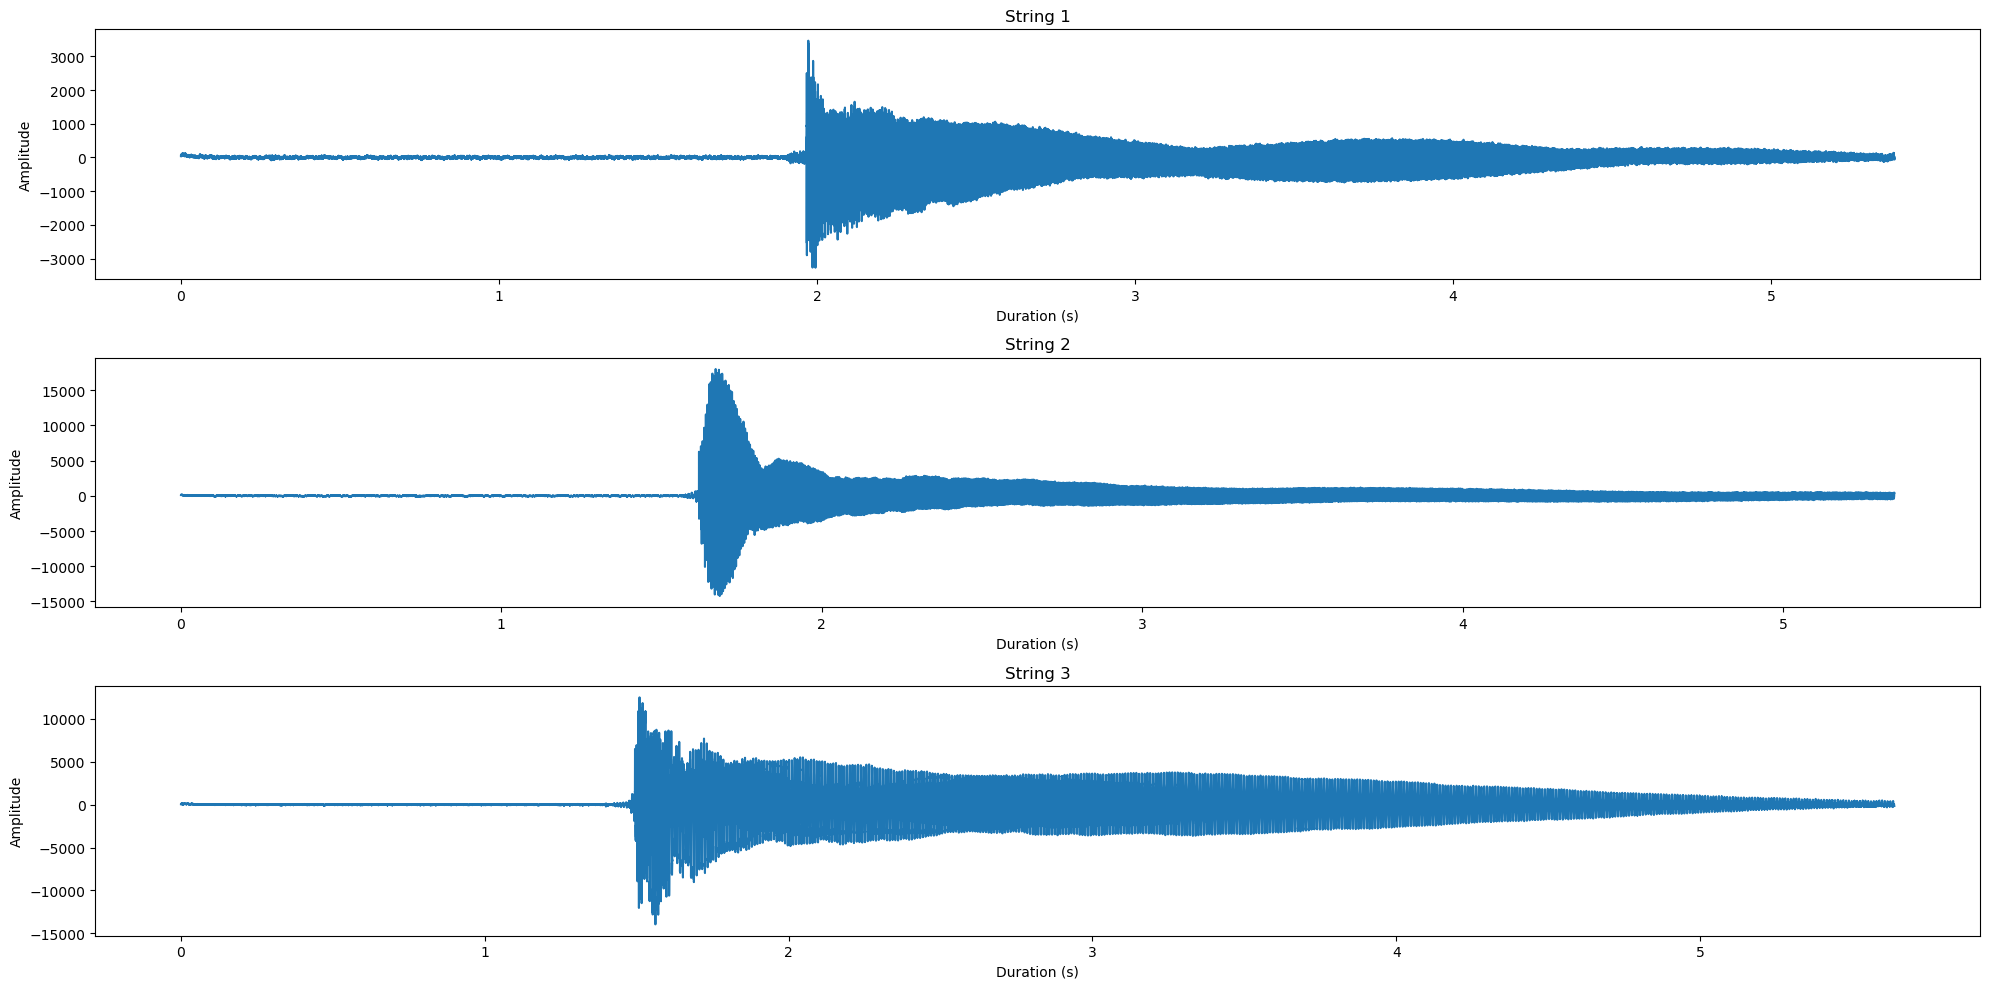

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
duration_1 = np.linspace(0, durations[0], len(signals[0]))
plt.plot(duration_1, signals[0])
plt.xlabel("Duration (s)")
plt.ylabel("Amplitude")
plt.title("String 1")
plt.subplot(3, 1, 2)
duration_2 = np.linspace(0, durations[1], len(signals[1]))
plt.plot(duration_2, signals[1])
plt.xlabel("Duration (s)")
plt.ylabel("Amplitude")
plt.title("String 2")
plt.subplot(3, 1, 3)
duration_3 = np.linspace(0, durations[2], len(signals[2]))
plt.plot(duration_3, signals[2])
plt.xlabel("Duration (s)")
plt.ylabel("Amplitude")
plt.title("String 3")
plt.tight_layout()
plt.show()


Some functions to:
1) compute the FFT
2) plot the frequencies
3) extract the most likely frequency using rolling average
4) return the note and cent accuracy

In [60]:
def get_fft(signal, sample_rate):
    """
    Compute the FFT of a signal and return the frequency and amplitude for the positive-amplitude frequencies.
    Arguments:
        signal - the signal to compute the FFT of
        sample_rate - the sample rate of the signal
    Returns:
        freq - the frequencies corresponding to the FFT
        fft_out - the positive amplitudes of the FFT at each frequency
    """
    fft = np.fft.fft(signal)
    #take half of the fourier transform
    fft_out = 2/len(fft) * np.abs(fft[0:int(len(fft)/2)])
    freq = np.fft.fftfreq(len(fft), 1/sample_rate)
    freq = freq[:int(len(freq)/2)]
    return freq, fft_out

def plot_freq(freq, fft, title="", x_lim=1000, y_lim=None):
    """
    Plot the frequency and amplitude of a signal.
    Arguments:
        freq - the frequencies corresponding to the FFT
        fft - the positive amplitudes of the FFT at each frequency
        title - the title of the plot
        x_lim - the maximum x value to plot
        y_lim - the maximum y value to plot
    """
    plt.plot(freq, fft)
    plt.xlim(0,x_lim)
    plt.ylim(0,y_lim)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.show()

def find_best_frequency(freq, fft_out, window):
    """
    Find the most likely frequency of a signal using a rolling average. Will take the frequency of the middle index of the window with the highest average amplitude.
    Arguments:
        freq - the frequencies corresponding to the FFT
        fft_out - the positive amplitudes of the FFT at each frequency
        window - the number of points to average over (e.g. window=10 will average over 5 indices before and 5 after the middle index)
    Returns:
        max_freq - the frequency with the highest average amplitude
        max_avg - the highest average amplitude
    """
    max_avg = 0
    max_index = 0
    for i in range(window//2, len(fft_out)-window//2):
        avg = np.mean(fft_out[i-window//2:i+window//2])
        if avg > max_avg:
            max_avg = avg
            max_index = i
    return freq[max_index], max_avg

def get_note_cent_accuracy(frequency):
    """
    Determine the most note and its cent accuracy of a frequency.
    Arguments:
        frequency - the frequency to determine the note and cent accuracy of
    Returns:
        min_string - the string with the closest frequency in terms of cent distance
    """
    #identify the string with the closest frequency
    #return the note and cent distance
    min_cent = 100000
    min_string = ""
    for string in strings:
        cent = (strings[string] - frequency)/cent_accuracies[string]
        if np.abs(cent) < min_cent:
            min_cent = cent
            min_string = string
    return min_string, min_cent

##### Plot the FFT of these signals.

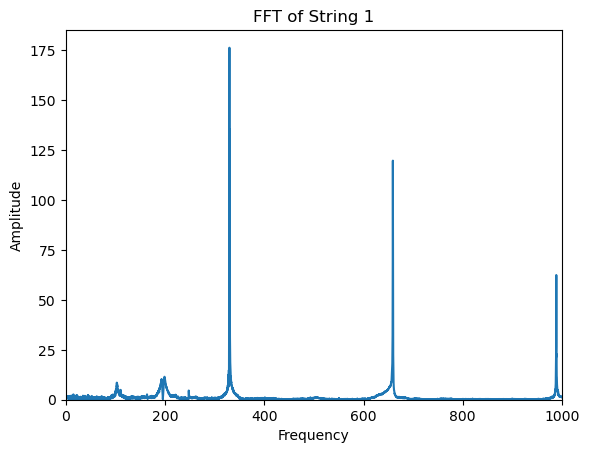

In [61]:
id = 0
freq, fft_out = get_fft(signals[id], sample_rates[id])
plot_freq(freq, fft_out, title="FFT of String %d" %(id+1), x_lim=1000)


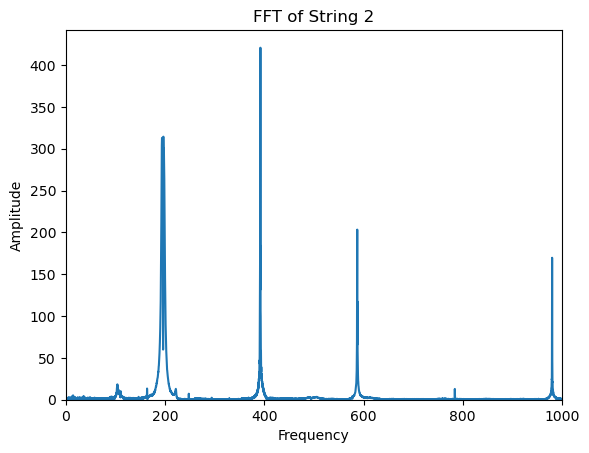

In [62]:
id = 1
freq, fft_out = get_fft(signals[id], sample_rates[id])
plot_freq(freq, fft_out, title="FFT of String %d" %(id+1), x_lim=1000)

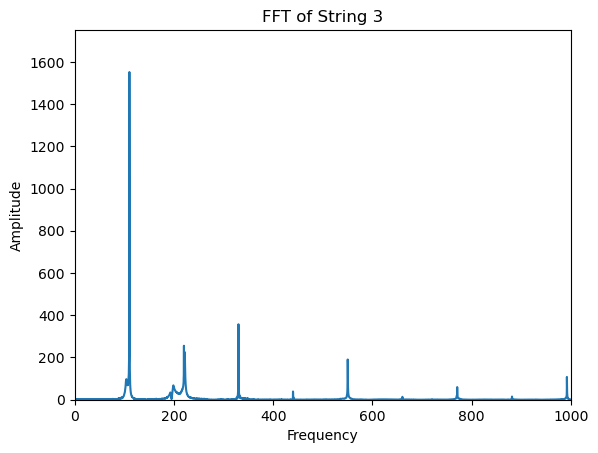

In [63]:
id = 2
freq, fft_out = get_fft(signals[id], sample_rates[id])
plot_freq(freq, fft_out, title="FFT of String %d" %(id+1), x_lim=1000, y_lim=1750)

##### Identify the string and cent distance.

In [64]:
window = 2
for window_choice in range(10):
    window = int(window * 1.618)
    print("Window size: %d" %window)
    cents_full = []
    for i, (signal, sample_rate) in enumerate(zip(signals, sample_rates)):
        freq, fft_out = get_fft(signal, sample_rate)
        frequency, max_avg = find_best_frequency(freq, fft_out, window=window)

        note, cent = get_note_cent_accuracy(frequency)
        cents_full.append([cent, note])
        print("String %d ; frequency %f Hz ; identified string %s with a cent distance of %f" % (i, frequency, note, cent))

Window size: 3
String 0 ; frequency 329.680765 Hz ; identified string E1 with a cent distance of -0.338434
String 1 ; frequency 392.147110 Hz ; identified string E1 with a cent distance of -416.780731
String 2 ; frequency 110.299653 Hz ; identified string A5 with a cent distance of -3.745657
Window size: 4
String 0 ; frequency 329.866396 Hz ; identified string E1 with a cent distance of -1.575974
String 1 ; frequency 193.923010 Hz ; identified string G3 with a cent distance of 13.846597
String 2 ; frequency 110.299653 Hz ; identified string A5 with a cent distance of -3.745657
Window size: 6
String 0 ; frequency 329.866396 Hz ; identified string E1 with a cent distance of -1.575974
String 1 ; frequency 193.923010 Hz ; identified string G3 with a cent distance of 13.846597
String 2 ; frequency 110.299653 Hz ; identified string A5 with a cent distance of -3.745657
Window size: 9
String 0 ; frequency 330.052027 Hz ; identified string E1 with a cent distance of -2.813515
String 1 ; frequen

In [65]:
window = 22
cents_full = []
for i, (signal, sample_rate) in enumerate(zip(signals, sample_rates)):
    freq, fft_out = get_fft(signal, sample_rate)
    frequency, max_avg = find_best_frequency(freq, fft_out, window=window)

    note, cent = get_note_cent_accuracy(frequency)
    cents_full.append([cent, note])
print("The best performance is achieved with window=22:")
print(cents_full)

The best performance is achieved with window=22:
[[-5.288595545976781, 'E1'], [3.8730578736686994, 'G3'], [2.9042414591778254, 'A5']]
